In [5]:
import torch
import torch.nn as nn
import torch.optim

from torch.utils.data import TensorDataset, DataLoader

In [6]:
mu_1 = np.array([-1, 0])
mu_2 = np.array([1, 0])

cov =np.array([[1.0, 0.0],
               [0.0, 10.0]])  ## One dimension has way more variance than the other. 

In [108]:
class mini_multihead(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 100, bias=False)
        self.fc11 = nn.Linear(100, 1, bias=False)

        self.fc2 = nn.Linear(1, 2, bias=True)
        self.fc2.weight.requires_grad = False
        self.fc2.weight.data.fill_(1)
        self.fc2.bias.data.fill_(0)
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x, tasks):
        x = self.fc1(x)
        x = self.fc11(x)
        
        logits = self.fc2(x)
        logits = logits.reshape(-1, 2, 1)
        # Select only relevant logits based on task
        logits = logits[torch.arange(logits.size(0)), list(tasks), 0]
        logits = self.sigmoid(logits)
        
        return logits

In [3]:
def get_data(n=4, m=10, delta=(1, 0), rot=False):
    # make sure m, n are even
    
    delta = np.array(delta)
    n = n//2
    m = m//2 

    # Target data
    xt_1 = np.random.multivariate_normal(mu_1, cov, size=n)
    xt_2 = np.random.multivariate_normal(mu_2, cov, size=n)
    xt = np.concatenate([xt_1, xt_2])
    yt = np.concatenate([np.repeat(0, n), np.repeat(1, n)])

    # OOD data    
    if rot:
        xo_1 = np.random.multivariate_normal(mu_1 @ delta, cov, size=m)
        xo_2 = np.random.multivariate_normal(mu_2 @ delta, cov, size=m)
    else:
        xo_1 = np.random.multivariate_normal(mu_1 + delta, cov, size=m)
        xo_2 = np.random.multivariate_normal(mu_2 + delta, cov, size=m)
    xo = np.concatenate([xo_1, xo_2])
    yo = np.concatenate([np.repeat(0, m), np.repeat(1, m)])

    return xt, yt, xo, yo


def get_dataloader(n=4, m=10, delta=(1, 0), rot=False):
    # make sure m, n are even
    xt, yt, xo, yo = get_data(n, m, delta, rot)

    xdat = np.concatenate([xt, xo])
    ydat = np.concatenate([yt, yo])
    tdat = np.concatenate([np.repeat(0, n), np.repeat(1, m)])
    ydat = np.array([tdat, ydat]).T
    
    xdat = torch.Tensor(xdat)
    ydat = torch.Tensor(ydat)

    dataset_t = TensorDataset(xdat, ydat)
    dataloader_t = DataLoader(dataset_t, batch_size=16, shuffle=True)

    return dataloader_t

In [129]:
def evaluate(ep, net, testloader):
    size = len(testloader.dataset)
    correct = 0.0
    with torch.inference_mode():
        for dat, target in testloader:
            task, lab = target[:, 0], target[:, 1]
            pred = net(dat, task)
            pred = (pred > 0.5)
            correct += (pred == lab).type(torch.float).sum().item()

    correct /= size
    return 1 - correct

In [130]:
testloader = get_dataloader(n=50000, m=0)

In [169]:
def train_net(n, m, d, rot=False):
    vals = []
    criterion = nn.BCELoss()
    for rep in range(10):
        trainloader = get_dataloader(n=n, m=m, delta=d, rot=rot)
        net = mini_multihead()
        optimizer = torch.optim.SGD(net.parameters(), lr=0.05)
        for ep in range(100):
            for dat, target in trainloader:
                task, lab = target[:, 0], target[:, 1]

                optimizer.zero_grad()
                out = net(dat, task)
                loss = criterion(out, lab)
                loss.backward()
                optimizer.step()

        vals.append(evaluate(ep+1, net, testloader))
    return np.mean(vals), np.std(vals), net

In [161]:
preds = {}
nval = 2
mval = list(range(0, 401, 40))
dval = [0.0, 1.0, 2.5, 5.0]

for d in dval:
    print("Computing for delta=%f" % d)
    delt = np.array((d, 0.0))
    preds[d] = []
    for m in mval:
        print("Computing for m=%d" % m)
        met = train_net(nval, m, delt)
        preds[d].append((m, met[0], met[1]))

Computing for delta=0.000000
Computing for m=0
Computing for m=40
Computing for m=80
Computing for m=120
Computing for m=160
Computing for m=200
Computing for m=240
Computing for m=280
Computing for m=320
Computing for m=360
Computing for m=400
Computing for delta=1.000000
Computing for m=0
Computing for m=40
Computing for m=80
Computing for m=120
Computing for m=160
Computing for m=200
Computing for m=240
Computing for m=280
Computing for m=320
Computing for m=360
Computing for m=400
Computing for delta=2.500000
Computing for m=0
Computing for m=40
Computing for m=80
Computing for m=120
Computing for m=160
Computing for m=200
Computing for m=240
Computing for m=280
Computing for m=320
Computing for m=360
Computing for m=400
Computing for delta=5.000000
Computing for m=0
Computing for m=40
Computing for m=80
Computing for m=120
Computing for m=160
Computing for m=200
Computing for m=240
Computing for m=280
Computing for m=320
Computing for m=360
Computing for m=400


In [162]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

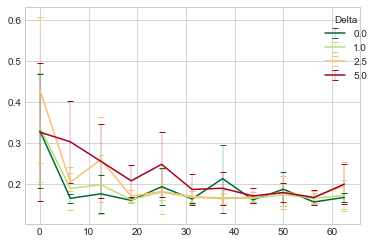

In [180]:
mnorm = [m/nval for m in mval]
color_idx = np.linspace(0, 1, len(preds))
dlist = sorted(preds.keys())
leg = [str(d) for d in dlist]

for i, d in enumerate(dlist):
    col = plt.cm.RdYlGn_r(color_idx[i])
    
    vals = preds[d]
    vals = np.array(vals)
    mean = vals[:, 1]
    std = vals[:, 2]
    markers, caps, bars = plt.errorbar(mnorm, mean, std, color=col,  capsize=3, capthick=1)
    [bar.set_alpha(0.2) for bar in bars]

plt.legend(leg, bbox_to_anchor = (1.05, 1.0), title='Delta')
plt.savefig("../reports/figures/02-rr-multihead_gaussian_translation.pdf", bbox_inches="tight")
plt.show()

In [158]:
preds = {}
nval = 8
mval = list(range(0, 1001, 100))
dval = [0.0, 1.0, 5.0]

for d in dval:
    print("Computing for delta=%f" % d)
    delt = np.array((d, 0.0))
    preds[d] = []
    for m in mval:
        print("Computing for m=%d" % m)
        met = train_net(nval, m, delt)
        preds[d].append((m, met[0], met[1]))

Computing for delta=0.000000
Computing for m=0
Computing for m=100
Computing for m=200
Computing for m=300
Computing for m=400
Computing for m=500
Computing for m=600
Computing for m=700
Computing for m=800
Computing for m=900
Computing for m=1000
Computing for delta=1.000000
Computing for m=0
Computing for m=100
Computing for m=200
Computing for m=300
Computing for m=400
Computing for m=500
Computing for m=600
Computing for m=700
Computing for m=800
Computing for m=900
Computing for m=1000
Computing for delta=5.000000
Computing for m=0
Computing for m=100
Computing for m=200
Computing for m=300
Computing for m=400
Computing for m=500
Computing for m=600
Computing for m=700
Computing for m=800
Computing for m=900
Computing for m=1000


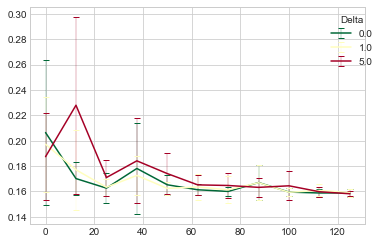

In [159]:
mnorm = [m/nval for m in mval]
color_idx = np.linspace(0, 1, len(preds))
dlist = sorted(preds.keys())
leg = [str(d) for d in dlist]

for i, d in enumerate(dlist):
    col = plt.cm.RdYlGn_r(color_idx[i])
    
    vals = preds[d]
    vals = np.array(vals)
    mean = vals[:, 1]
    std = vals[:, 2]
    markers, caps, bars = plt.errorbar(mnorm, mean, std, color=col,  capsize=3, capthick=1)
    [bar.set_alpha(0.2) for bar in bars]

plt.legend(leg, bbox_to_anchor = (1.05, 1.0), title='Delta')
plt.show()

# Multihead with Rotations

In [176]:
preds_rot = {}
nval = 8
mval = list(range(0, 501, 50))
dval = [0, 10, 30, 45, 90]

for d in dval:
    print("Computing for delta=%f" % d)
    rad = (d / 180) * np.pi
    delt = np.array([[np.cos(rad), np.sin(rad)],
                     [-np.sin(rad), np.cos(rad)]])
    preds_rot[d] = []
    for m in mval:
        print("Computing for m=%d" % m)
        met = train_net(nval, m, delt, rot=True)
        preds_rot[d].append((m, met[0], met[1]))

Computing for delta=0.000000
Computing for m=0
Computing for m=50
Computing for m=100
Computing for m=150
Computing for m=200
Computing for m=250
Computing for m=300
Computing for m=350
Computing for m=400
Computing for m=450
Computing for m=500
Computing for delta=10.000000
Computing for m=0
Computing for m=50
Computing for m=100
Computing for m=150
Computing for m=200
Computing for m=250
Computing for m=300
Computing for m=350
Computing for m=400
Computing for m=450
Computing for m=500
Computing for delta=30.000000
Computing for m=0
Computing for m=50
Computing for m=100
Computing for m=150
Computing for m=200
Computing for m=250
Computing for m=300
Computing for m=350
Computing for m=400
Computing for m=450
Computing for m=500
Computing for delta=45.000000
Computing for m=0
Computing for m=50
Computing for m=100
Computing for m=150
Computing for m=200
Computing for m=250
Computing for m=300
Computing for m=350
Computing for m=400
Computing for m=450
Computing for m=500
Computing for

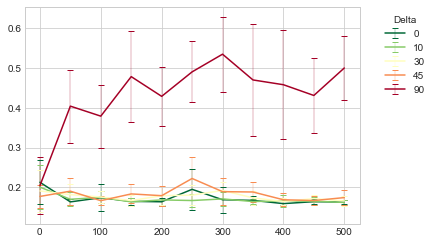

In [178]:
mnorm = mval
color_idx = np.linspace(0, 1, len(preds_rot))
dlist = sorted(preds_rot.keys())
leg = [str(d) for d in dlist]

for i, d in enumerate(dlist):
    col = plt.cm.RdYlGn_r(color_idx[i])
    
    vals = preds_rot[d]
    vals = np.array(vals)
    mean = vals[:, 1]
    std = vals[:, 2]
    markers, caps, bars = plt.errorbar(mnorm, mean, std, color=col,  capsize=3, capthick=1)
    [bar.set_alpha(0.2) for bar in bars]

plt.legend(leg, bbox_to_anchor = (1.05, 1.0), title='Delta')
plt.savefig("../reports/figures/02-rr-multihead_gaussian_rotations.pdf", bbox_inches="tight")
plt.show()

# Plotting Gaussians

In [44]:
import seaborn as sns
import pandas as pd
sns.set_theme()
plt.style.use('seaborn-whitegrid')

In [99]:
mu_1 = np.array([-2, 0])
mu_2 = np.array([2, 0])

cov =np.array([[1.0, 0.0],
               [0.0, 10.0]])  ## One dimension has way more variance than the other. 

dat = get_data(n=1000, m=1000, delta=(5, -7), rot=False)
xt, yt, xo, yo = dat
table = []
for val in xt:
    table.append(list(val) + ['Target'])
for val in xo:
    table.append(list(val) + ['OOD'])
table = pd.DataFrame(table)
table.columns = ['x', 'y', 'task']

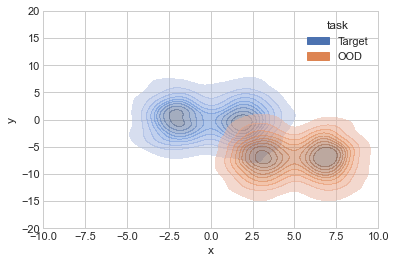

In [100]:
sns.kdeplot(
    data=table, x="x", y="y", hue="task", fill=True, alpha=0.5
)
plt.xlim([-10, 10])
plt.ylim([-20, 20])
plt.savefig("../reports/figures/02-rr-multihead_gaussian_ex1.pdf", bbox_inches="tight")
plt.show()

In [101]:
mu_1 = np.array([-2, 0])
mu_2 = np.array([2, 0])

cov =np.array([[1.0, 0.0],
               [0.0, 10.0]])  ## One dimension has way more variance than the other. 
dat = get_data(n=1000, m=1000, delta=(5, 0), rot=False)
xt, yt, xo, yo = dat
table = []
for val in xt:
    table.append(list(val) + ['Target'])
for val in xo:
    table.append(list(val) + ['OOD'])
table = pd.DataFrame(table)
table.columns = ['x', 'y', 'task']

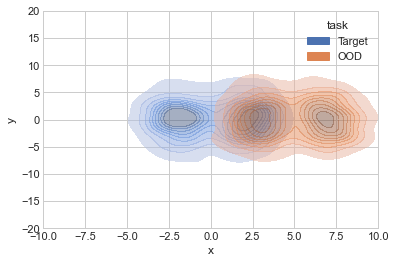

In [102]:
sns.kdeplot(
    data=table, x="x", y="y", hue="task", fill=True, alpha=0.5
)
plt.xlim([-10, 10])
plt.ylim([-20, 20])
plt.savefig("../reports/figures/02-rr-multihead_gaussian_ex2.pdf", bbox_inches="tight")

plt.show()

In [103]:
mu_1 = np.array([-2, 0])
mu_2 = np.array([2, 0])

cov =np.array([[1.0, 0.0],
               [0.0, 10.0]])  ## One dimension has way more variance than the other. 
rad = (45 / 180) * np.pi
delt = np.array([[np.cos(rad), np.sin(rad)],
                 [-np.sin(rad), np.cos(rad)]])


dat = get_data(n=1000, m=1000, delta=delt, rot=True)
xt, yt, xo, yo = dat
table = []
for val in xt:
    table.append(list(val) + ['Target'])
for val in xo:
    table.append(list(val) + ['OOD'])
table = pd.DataFrame(table)
table.columns = ['x', 'y', 'task']

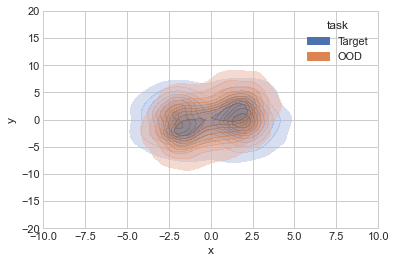

In [104]:
sns.kdeplot(
    data=table, x="x", y="y", hue="task", fill=True, alpha=0.5
)
plt.xlim([-10, 10])
plt.ylim([-20, 20])
plt.savefig("../reports/figures/02-rr-multihead_gaussian_ex3.pdf", bbox_inches="tight")

plt.show()

In [105]:
mu_1 = np.array([-2, 0])
mu_2 = np.array([2, 0])

cov =np.array([[1.0, 0.0],
               [0.0, 10.0]])  ## One dimension has way more variance than the other. 
rad = (90 / 180) * np.pi
delt = np.array([[np.cos(rad), np.sin(rad)],
                 [-np.sin(rad), np.cos(rad)]])


dat = get_data(n=1000, m=1000, delta=delt, rot=True)
xt, yt, xo, yo = dat
table = []
for val in xt:
    table.append(list(val) + ['Target'])
for val in xo:
    table.append(list(val) + ['OOD'])
table = pd.DataFrame(table)
table.columns = ['x', 'y', 'task']

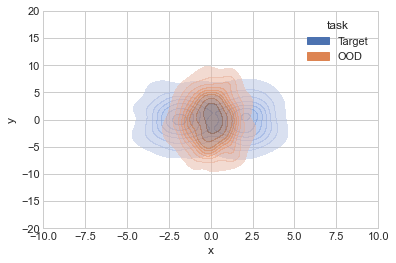

In [106]:
sns.kdeplot(
    data=table, x="x", y="y", hue="task", fill=True, alpha=0.5
)
plt.xlim([-10, 10])
plt.ylim([-20, 20])
plt.savefig("../reports/figures/02-rr-multihead_gaussian_ex4.pdf", bbox_inches="tight")

plt.show()